In [19]:
import numpy as np
import tensorflow as tf

In [20]:
# amazingly, this fixes plotting on Harish's Mac!
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [21]:
# this function seeks to ensure reproducibility
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [22]:
traj = np.loadtxt('mydwNEW.csv',delimiter=',')
traj = np.transpose(np.reshape(traj,(2,10001,2)),[1,0,2])
qdat = traj[:5001,:,[0]]
pdat = traj[:5001,:,[1]]
n_steps, n_instances, d = qdat.shape
dt = 0.001
print(qdat.shape)
print(pdat.shape)

(5001, 2, 1)
(5001, 2, 1)


In [23]:
def tf_diff_axis_0(a):
    return a[1:]-a[:-1]

In [24]:
# # assume data is in the form: n_steps x n_instances x d
# qdat = np.array([[[0.3, -0.5, 1.0, 7.0],[3.7,-0.4,-0.15, -7.0]], 
#                  [[-7.0,3.14,2.5, 8.0],[3.7,-0.4,-0.15, -7.0]], 
#                  [[2.0,6.14,9.5,9.0],[3.7,-0.4,-0.15, -7.0]]])
# pdat = np.random.normal(size=qdat.shape)
# print(qdat.shape)
# n_steps, n_instances, d = qdat.shape

In [25]:
# set up a neural network model for a potential function V : R^d --> R
reset_graph()

# here we take both q and p to be n_steps x n_instances x d
qts = tf.placeholder(tf.float32, shape=(None, n_instances, d), name="qts")
pts = tf.placeholder(tf.float32, shape=(None, n_instances, d), name="pts")

# flatten in such a way that we get a two-dimensional matrix consisting of blocks
# each block consists of one instance of dimension n_steps x d
# the number of such blocks is n_instances
q = tf.transpose(tf.layers.flatten(tf.transpose(qts, perm=[2, 1, 0])),perm=[1, 0])

# keep track of outputs of each layer
output = []

# put the inputs in output[0]
output.append(q)

# here is a little Python magic that enables us to define a new function
# called "my_dense_layer" which is the same as the TF function tf.layers.dense
# except that we have preset activation=selu
# ...in short, we have partially evaluated tf.layers.dense...
from functools import partial
my_dense_layer = partial(tf.layers.dense,activation=tf.nn.tanh)

In [26]:
depth = 2
numneurons = [16, 16]

# here is where we define our deep neural network
with tf.name_scope("dnn"):
    
    # we iteratively create hidden layers
    for j in range(depth):
        thisname = "hidden" + str(j)
        
        # the input to hidden layer j is outputs[j]
        # the output of hidden layer j is stored in outputs[j+1]
        # this function handles the creation of all weight and bias variables,
        # for each hidden layer!
        output.append(my_dense_layer(output[j], 
                                     units=numneurons[j],
                                     name=thisname))

    # to get from the high-dimensional output of the final hidden layer
    # to a scalar output, we use this function, which basically uses 
    # a linear transformation of the form "w^T h + b"
    # --> h is the vector of outputs from the last hidden layer
    # --> w is a weight vector of the same dimension as h
    # --> b is a scalar
    Vpredraw = tf.layers.dense(output[depth], units=1, name='output')
    Vpred = tf.reshape(Vpredraw, shape=[n_instances, n_steps])

In [27]:
# automatically differentiate potential and generate gradV : R^d --> R^d
from tensorflow.python.ops.parallel_for.gradients import jacobian, batch_jacobian
gradVpredraw = batch_jacobian(Vpredraw, q)
gradVpred = tf.reshape(gradVpredraw, shape=[n_instances, n_steps, d])

In [28]:
# compute loss and set up optimizer
pdot = tf_diff_axis_0(pts)/dt
loss = tf.reduce_mean( tf.square( pdot + tf.transpose(gradVpred[:,:-1], perm=[1,0,2]) ) )
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
training_op = optimizer.minimize(loss)


In [29]:
# typical TF initialization
init = tf.global_variables_initializer()

# we set up TF to save its progress to disk
saver = tf.train.Saver()

In [30]:
with tf.Session() as sess:
    init.run()
    maxsteps = 50000
    for i in range(maxsteps):
        # we run the "training_op" defined above, corresponding to one optimization step
        # note that we must feed in xx and yy for the placeholders X and y
        sess.run(training_op, feed_dict={qts : qdat, pts : pdat})
        # periodically tell us what is happening to the loss function
        if (i % 1000) == 0:
            # note this is another way to grab the value of the loss function
            # we still have to feed in xx and yy for the placeholders X and y
            print(i, "Loss:", loss.eval(feed_dict={qts : qdat, pts : pdat}))
    # save final trained TF model to disk
    save_path = saver.save(sess, "./dblwell_NEW_model_final.ckpt")


0 Loss: 9.290698
1000 Loss: 0.710798
2000 Loss: 0.068882465
3000 Loss: 0.03797213
4000 Loss: 0.028383212
5000 Loss: 0.023295661
6000 Loss: 0.019900095
7000 Loss: 0.017384823
8000 Loss: 0.015415219
9000 Loss: 0.013813489
10000 Loss: 0.01247961
11000 Loss: 0.011347063
12000 Loss: 0.010370885
13000 Loss: 0.009519933
14000 Loss: 0.008770447
15000 Loss: 0.0081054
16000 Loss: 0.0075103804
17000 Loss: 0.0069743097
18000 Loss: 0.0064909216
19000 Loss: 0.006052268
20000 Loss: 0.005650612
21000 Loss: 0.0052843727
22000 Loss: 0.004949056
23000 Loss: 0.004641182
24000 Loss: 0.0043574953
25000 Loss: 0.004095918
26000 Loss: 0.0038542007
27000 Loss: 0.0036304104
28000 Loss: 0.0034231422
29000 Loss: 0.0032319573
30000 Loss: 0.0030543758
31000 Loss: 0.0028898472
32000 Loss: 0.0027360157
33000 Loss: 0.0025934025
34000 Loss: 0.0024606036
35000 Loss: 0.0023375072
36000 Loss: 0.0022219352
37000 Loss: 0.0021156243
38000 Loss: 0.0020147832
39000 Loss: 0.0019219047
40000 Loss: 0.0018348148
41000 Loss: 0.00175

In [31]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


INFO:tensorflow:Restoring parameters from ./dblwell_NEW_model_final.ckpt
(5001, 2, 1)
INFO:tensorflow:Restoring parameters from ./dblwell_NEW_model_final.ckpt


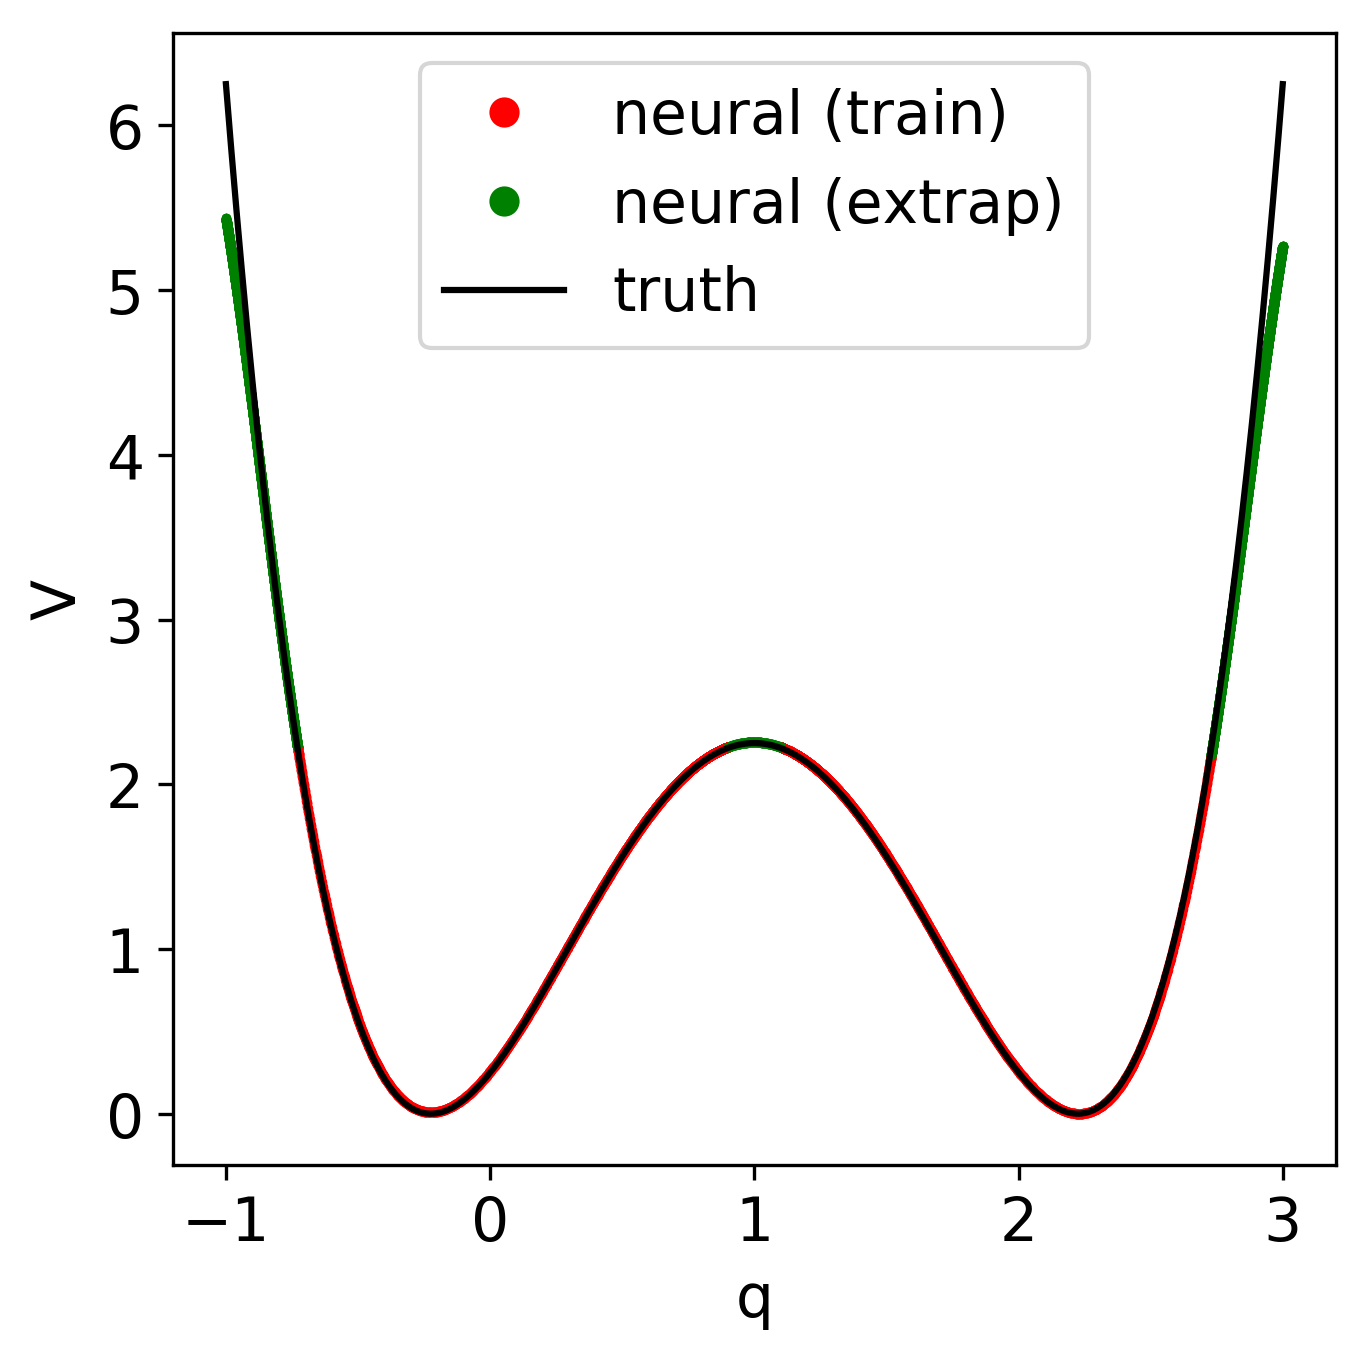

In [46]:
# here we grab the final model from disk and extract three things:
# the true values of x, the true values of y, and the predicted values of y
# n = 10

with tf.Session() as sess:
    saver.restore(sess, "./dblwell_NEW_model_final.ckpt")
    # xp = np.reshape(np.linspace(-4.0,4.0,n),[1,n,1])
    Vplot = sess.run(Vpred, feed_dict = {qts : qdat})

qdatpts = np.reshape(np.transpose(qdat,(1,0,2)),[10002])
Vplotpts = np.reshape(Vplot,[10002])
plt.figure(figsize=(5,5),dpi=300) 
plt.plot(qdatpts,Vplotpts - np.min(Vplotpts),'r.',ms=2.5, label='neural (train)')
np.savetxt(fname='dblwellVNEW.csv', X=Vplotpts, delimiter=',')
np.savetxt(fname='dblwellrNEW.csv', X=qdatpts, delimiter=',')

qdatptsEXTRAP = np.hstack([np.linspace(-1,np.min(qdatpts),2400),np.linspace(0.9,1.1,200),np.linspace(np.max(qdatpts),3,2401)])
qdatEXTRAP = np.expand_dims(qdatptsEXTRAP,axis=1)
qdatEXTRAP = np.stack([qdatEXTRAP, qdatEXTRAP],axis=1)
print(qdatEXTRAP.shape)
with tf.Session() as sess:
    saver.restore(sess, "./dblwell_NEW_model_final.ckpt")
    # xp = np.reshape(np.linspace(-4.0,4.0,n),[1,n,1])
    VplotEXTRAP = sess.run(Vpred, feed_dict = {qts : qdatEXTRAP})

qdatptsEXTRAP = np.reshape(np.transpose(qdatEXTRAP,(1,0,2)),[10002])
VplotptsEXTRAP = np.reshape(VplotEXTRAP,[10002])
plt.plot(qdatptsEXTRAP,VplotptsEXTRAP - np.min(Vplotpts),'g.',ms=2.5, label='neural (extrap)')


x = np.linspace(-1,3,1000)
trueV = x*x*(x-2)*(x-2) - (x-1)**2
plt.plot(x,trueV - np.min(trueV),'k-',lw=1.5, label='truth')
plt.legend(markerscale=5,loc=9)
plt.xlabel('q')
plt.ylabel('V')
plt.savefig('dblwell_NEW.pdf')
plt.show()

In [26]:
# debugging code to check shape of kernels
dg = tf.get_default_graph()
alltens = [n.name for n in tf.get_default_graph().as_graph_def().node]
print(dg.get_tensor_by_name('hidden0/kernel:0'))
print(dg.get_tensor_by_name('hidden1/kernel:0'))
print(dg.get_tensor_by_name('output/kernel:0'))

Tensor("hidden0/kernel:0", shape=(4, 4), dtype=float32_ref)
Tensor("hidden1/kernel:0", shape=(4, 4), dtype=float32_ref)
Tensor("output/kernel:0", shape=(4, 1), dtype=float32_ref)


In [10]:
# need a few pieces here
# get (q,p) time series data as input

# compute -\grad V(q)
# compute loss function \| \dot{p} + \grad V(q) \|^2

